In [221]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from wordcloud import WordCloud
import os
import re
import ftfy
from nltk.corpus import stopwords
from nltk import PorterStemmer
import nltk
import word2vec
import keras
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint ,ReduceLROnPlateau
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
import datetime
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/amr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/amr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [222]:
data_dir="../depressionAnalysis/input"
data_file_names = os.listdir(data_dir)
print('filenames:',data_file_names)
encoding='ISO-8859-1'
columns = ['target','id','data','flag','user','text']

df_sentiment = pd.read_csv(os.path.join(data_dir,data_file_names[1]),encoding=encoding, names=columns) #sentiment 140 data from kaggle
df_depressive = pd.read_csv(os.path.join(data_dir,data_file_names[2]), sep = '|', header = None, usecols = range(0,9)) #depressive tweets obtained by scraping with twint
df_depressive2 = pd.read_csv('depressed.csv',dtype=str)
df_depressive2 = df_depressive2[['tweet']]
labels = np.array([1]*len(df_depressive2))
df_depressive2.columns = ['text']
df_depressive2['label'] = labels

filenames: ['vader_processed_final.csv', 'training.1600000.processed.noemoticon.csv', 'depressive_tweets_processed.txt']


In [223]:
df_sentiment=df_sentiment.copy().sample(8000, random_state=42)
df_sentiment["label"]=0
df_sentiment=df_sentiment[['text','label']]
df_sentiment.dropna(inplace=True)
print(df_sentiment.head())


df_depressive["label"] = 1
df_depressive=df_depressive[[5,'label']]
df_depressive.dropna(inplace=True)
df_depressive.rename(columns={5:'text'},inplace=True)

df_depressive = df_depressive.append(df_depressive2)
print(df_depressive.head())
df_depressive.info()
df_sentiment.info()


                                                     text  label
541200             @chrishasboobs AHHH I HOPE YOUR OK!!!       0
750     @misstoriblack cool , i have no tweet apps  fo...      0
766711  @TiannaChaos i know  just family drama. its la...      0
285055  School email won't open  and I have geography ...      0
705995                             upper airways problem       0
                                                text  label
0  The lack of this understanding is a small but ...      1
1  i just told my parents about my depression and...      1
2  depression is something i don't speak about ev...      1
3  Made myself a tortilla filled with pb&j. My de...      1
4  @WorldofOutlaws I am gonna need depression med...      1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3313 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3313 non-null   object
 1   label   3313 non-null   int64 
d

In [224]:
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))
def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links then dont append to avoid news articles
        # also check tweet length, save those > 10 (length of word "depression")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #remove hashtag, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())

            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)

            #expand contraction
            tweet = expandContractions(tweet)

            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet)
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)

            cleaned_tweets.append(tweet)

    return cleaned_tweets

In [225]:
depressive_tweets = [x for x in df_depressive['text']]
random_tweets =[x for x in df_sentiment['text']]
c_depressive_tweets = clean_tweets(depressive_tweets)
c_random_tweets = clean_tweets(random_tweets)

In [226]:
depressive_words = ''.join(list(map(str,depressive_tweets)))
depressive_wc = WordCloud(width=512,height=512,collocations=False,colormap="Blues").generate(depressive_words)

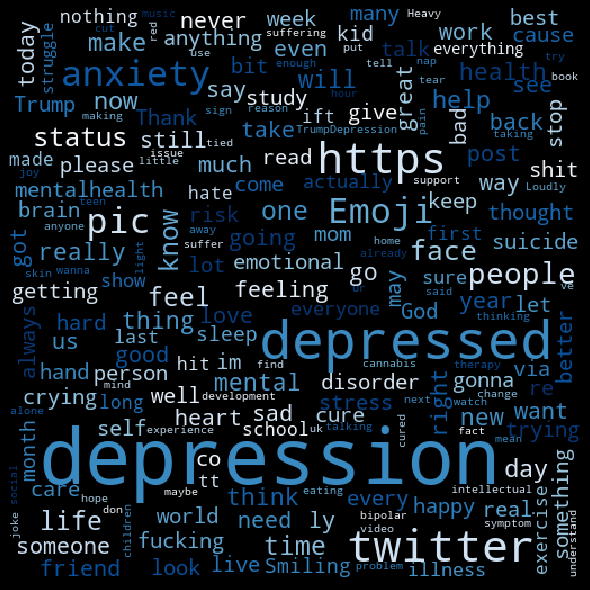

In [227]:
plt.figure(figsize=(10, 8),facecolor='k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [228]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(c_depressive_tweets+c_random_tweets)

sequences_depressive = tokenizer.texts_to_sequences(c_depressive_tweets)
sequences_random = tokenizer.texts_to_sequences(c_random_tweets)

word_index = tokenizer.word_index
print('found %s unique tokens'% len(word_index))

data_depressive = pad_sequences(sequences_depressive,maxlen=140)
data_random = pad_sequences(sequences_random,maxlen=140)

print('shape of data_depressive:',data_depressive.shape)
print('shape of data_random:',data_random.shape)

#Embedding Matrix
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
nb_words = min(20000,len(word_index))
embedding_matrix = np.zeros((nb_words+1,300)) #300 being the Embedding dimension

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < 300:
        embedding_matrix[idx] = word2vec.word_vec(word)

found 18420 unique tokens
shape of data_depressive: (3305, 140)
shape of data_random: (7920, 140)


In [229]:
#splitting and formatting the data
labels_depressive = np.array([1]*len(c_depressive_tweets))
labels_random = np.array([0]*len(c_random_tweets))

#splitting the arrays int 60,20,20
perm_depressive = np.random.permutation(len(data_depressive))
index_train_depressive = perm_depressive[:int(len(data_depressive)*0.6)]
index_test_depressive = perm_depressive[int(len(data_depressive)*(0.6)):int(len(data_depressive)*(0.6+0.2))]
index_valid_depressive = perm_depressive[int(len(data_depressive)*(0.6+0.2)):]

perm_random = np.random.permutation(len(data_random))
index_train_random = perm_random[:int(len(data_random)*0.6)]
index_test_random = perm_random[int(len(data_random)*(0.6)):int(len(data_random)*(0.6+0.2))]
index_valid_random = perm_random[int(len(data_random)*(0.6+0.2)):]

#combining depressive and random tweets
data_train = np.concatenate((data_depressive[index_train_depressive], data_random[index_train_random]))
labels_train = np.concatenate((labels_depressive[index_train_depressive], labels_random[index_train_random]))
data_test = np.concatenate((data_depressive[index_test_depressive], data_random[index_test_random]))
labels_test = np.concatenate((labels_depressive[index_test_depressive], labels_random[index_test_random]))
data_val = np.concatenate((data_depressive[index_valid_depressive], data_random[index_valid_random]))
labels_val = np.concatenate((labels_depressive[index_valid_depressive], labels_random[index_valid_random]))

#shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

In [230]:
checkpoint_path = "/home/amr/PycharmProjects/depressionAnalysis/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only= True, verbose=1)

In [231]:
#building the model
model = Sequential()
# Embedded layer

model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix],
                            input_length=140, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

model.save_weights(checkpoint_path.format(epoch=0))


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 140, 300)          5526300   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 70, 32)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 70, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               399600    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [25]:
# Training The Model
early_stop = EarlyStopping(monitor='val_loss', patience=3)
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5),cp_callback]

In [232]:
EPOCHS = 20
hist = model.fit(data_train, labels_train,
         validation_data=(data_val, labels_val),
         epochs=EPOCHS, batch_size=40, shuffle=True,
         callbacks=callbacks)

Train on 6735 samples, validate on 2245 samples
Epoch 1/20
6735/6735 [==============================] - 106s 16ms/step - loss: 0.1817 - acc: 0.9440 - val_loss: 0.0545 - val_acc: 0.9898

Epoch 00001: saving model to /home/amr/PycharmProjects/depressionAnalysis/training_1/cp.ckpt
Epoch 2/20
6735/6735 [==============================] - 90s 13ms/step - loss: 0.0576 - acc: 0.9880 - val_loss: 0.0513 - val_acc: 0.9898

Epoch 00002: saving model to /home/amr/PycharmProjects/depressionAnalysis/training_1/cp.ckpt
Epoch 3/20
6735/6735 [==============================] - 88s 13ms/step - loss: 0.0550 - acc: 0.9875 - val_loss: 0.0580 - val_acc: 0.9889

Epoch 00003: saving model to /home/amr/PycharmProjects/depressionAnalysis/training_1/cp.ckpt
Epoch 4/20
6735/6735 [==============================] - 92s 14ms/step - loss: 0.0557 - acc: 0.9877 - val_loss: 0.0494 - val_acc: 0.9893

Epoch 00004: saving model to /home/amr/PycharmProjects/depressionAnalysis/training_1/cp.ckpt
Epoch 5/20
6735/6735 [=========

In [233]:
score = model.evaluate(data_test, labels_test, batch_size=40)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

2245/2245 [==============================] - 6s 3ms/step

ACCURACY: 0.988418698310852
LOSS: 0.05555251983299287


In [28]:
# model.save('saved_model/my_model')

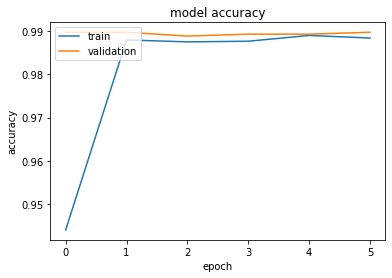

In [234]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [235]:
def decode_sentiment(score):
        return 'neutral' if score < 0.5 else 'depressed'

In [236]:

def predict(text):
    
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=140)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score)}  

In [240]:
predict('i was diagnosed with anxiety and stress')

{'label': 'depressed', 'score': 0.8790684342384338}

In [245]:
predict('this so depressing')

{'label': 'neutral', 'score': 0.03155031055212021}

In [254]:
predict('my mental health is so low')

{'label': 'depressed', 'score': 0.9223478436470032}

In [264]:
random_words = ''.join(list(map(str,random_tweets)))
random_wc = WordCloud(width=512,height=512,collocations=False,colormap="Blues").generate(random_words)

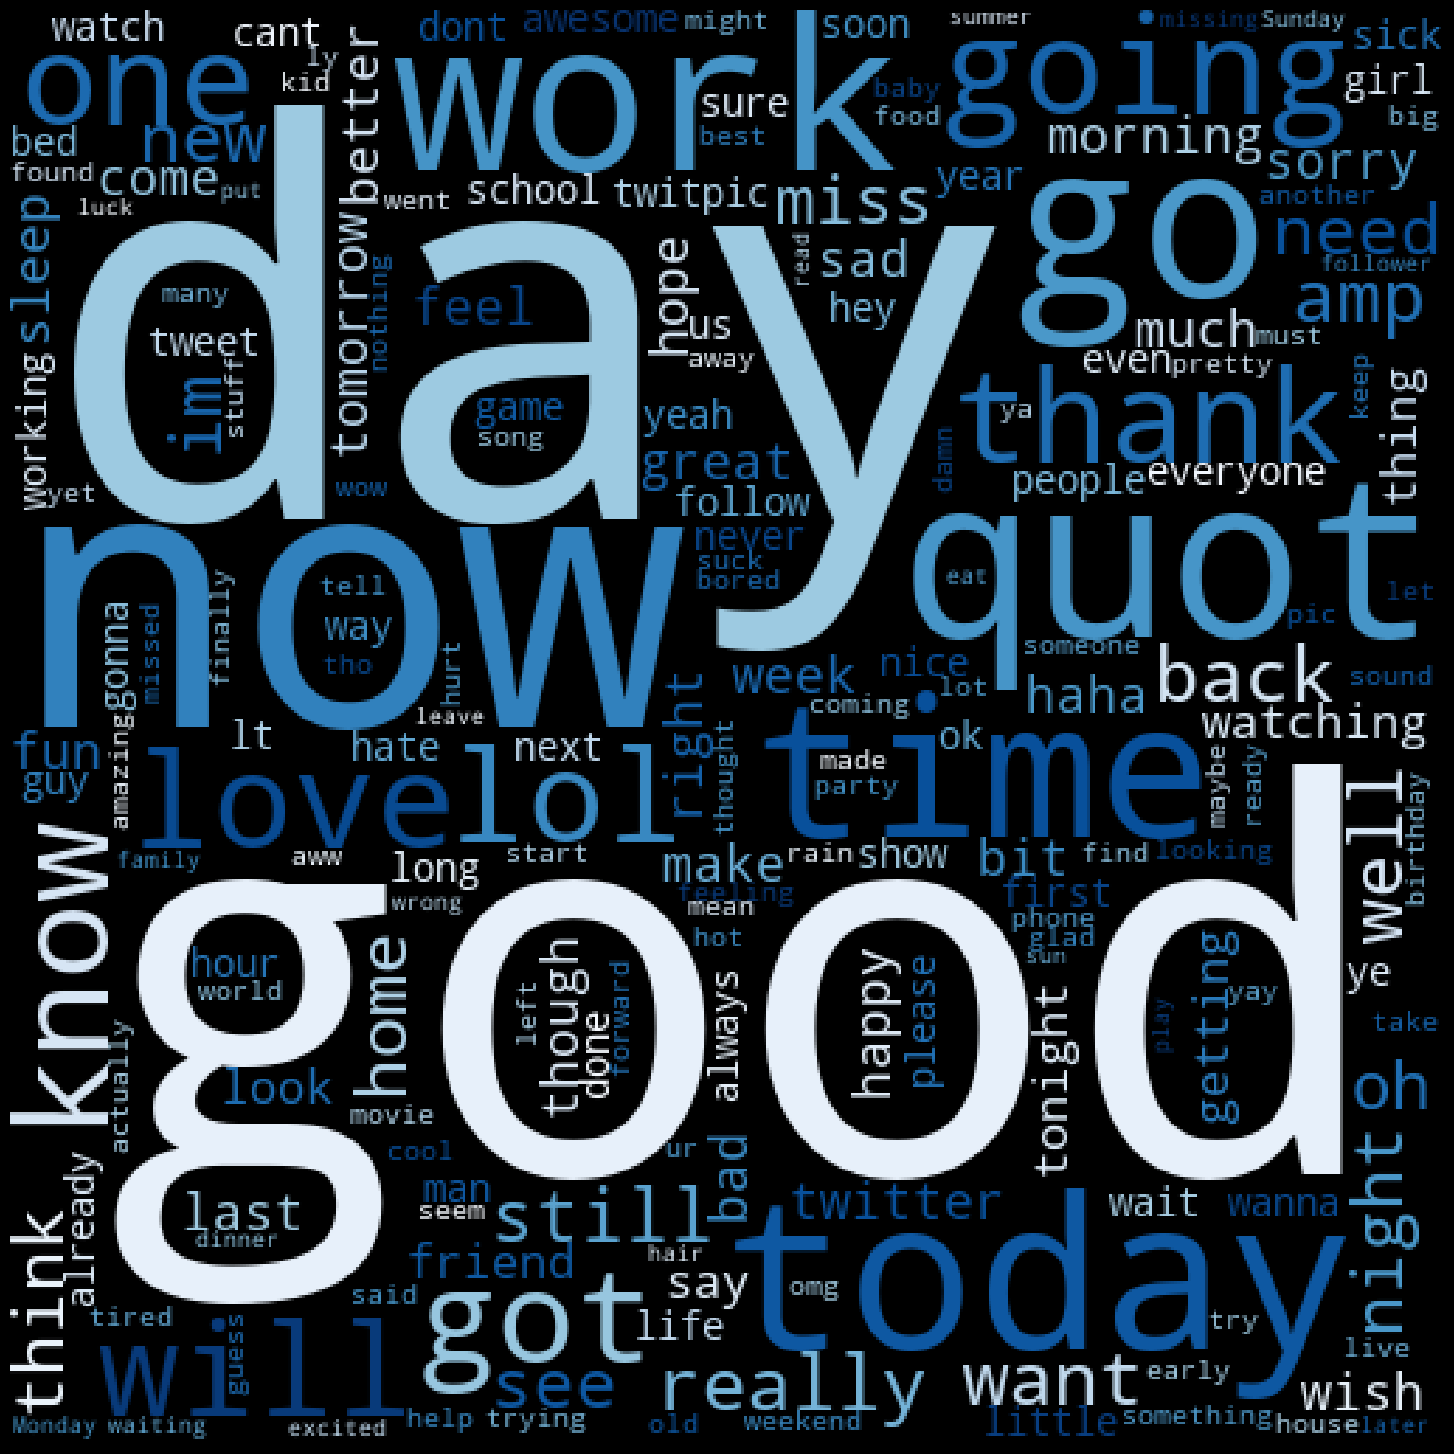

In [266]:
plt.figure(figsize=(20, 20),facecolor='k')
plt.imshow(random_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

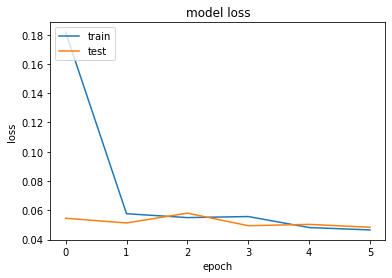

In [268]:

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()